<a href="https://colab.research.google.com/github/curtiscu/LYIT/blob/master/2020_11_26_tryingStuffLikePCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building on GridSearchCV, need to try PCA

# Setup Colab env


In [1]:

import sklearn
sklearn.__version__
!pip install --upgrade scikit-learn

#!pip uninstall scikit-learn -y
#!pip install scikit-learn

     |████████████████████████████████| 6.8MB 4.0MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [ ]:
# print all cell output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


## Google drive access

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
# peek at data
! ls -al '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/'

# peek at modules from local  'E:\Google Drive\LYIT\Dissertation\modules'
! ls -al '/content/drive/My Drive/LYIT/Dissertation/modules/'

total 35
-rw------- 1 root root 2589 Apr 27  2020 10_soul-groove10_102_beat_4-4.mid
-rw------- 1 root root 4793 Apr 27  2020 1_funk-groove1_138_beat_4-4.mid
-rw------- 1 root root 3243 Apr 27  2020 2_funk-groove2_105_beat_4-4.mid
-rw------- 1 root root 4466 Apr 27  2020 3_soul-groove3_86_beat_4-4.mid
-rw------- 1 root root 2551 Apr 27  2020 4_soul-groove4_80_beat_4-4.mid
-rw------- 1 root root 3798 Apr 27  2020 5_funk-groove5_84_beat_4-4.mid
-rw------- 1 root root 3760 Apr 27  2020 6_hiphop-groove6_87_beat_4-4.mid
-rw------- 1 root root 1894 Apr 27  2020 7_pop-groove7_138_beat_4-4.mid
-rw------- 1 root root 2437 Apr 27  2020 8_rock-groove8_65_beat_4-4.mid
-rw------- 1 root root 3448 Apr 27  2020 9_soul-groove9_105_beat_4-4.mid
total 52
-rw------- 1 root root 29124 Nov 29 22:48 data_prep.py
-rw------- 1 root root  2904 Nov 18 21:57 pipeline_utils.py
drwx------ 2 root root  4096 May 10  2020 __pycache__
-rw------- 1 root root  7847 Aug 18 22:09 stats_n_features.py
-rw------- 1 root root 

## Auto reload module

Now using library code I've created and saved to google drive which is automatically pushed to the cloud and made available to the colab env. The autoreload stuff below should help imports to 'reimport' to load changes to the library code.

It's not the quickest/ most reliable, so if in a hurry, brute force loading of changes by restarting the runtime.

In [ ]:
# tool to auto reload modules.
%load_ext autoreload

# config to auto-reload all modules, handy to make 
# writing and testing modules much easier.
%autoreload 2

## Imports and accessing lib functions

In [ ]:
# install required libs
!pip install mido

     |████████████████████████████████| 61kB 3.1MB/s 


In [ ]:
# regular imports
import pandas as pd
import numpy as np

# scikit-learn
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import  MinMaxScaler, RobustScaler, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

# graphics/ charts
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# misc
from scipy import stats
from collections import namedtuple
import math
import datetime
from itertools import cycle

In [ ]:
import mido  # MIDI library processing
from mido import MidiFile
from mido import Message
from mido import tempo2bpm
from mido import tick2second

In [ ]:
# import my modules
import sys
sys.path.append('/content/drive/My Drive/LYIT/Dissertation/modules/')
import data_prep as dp
import pipeline_utils as pu
import stats_n_features as sf

>> LOADING custom module, when: 2020-11-30 20:20:37.080533, module name: stats_n_features
>> LOADING custom module, when: 2020-11-30 20:20:37.081676, module name: data_prep
>> LOADING custom module, when: 2020-11-30 20:20:37.303782, module name: pipeline_utils


In [ ]:
# test module function calls..
dp.test_function_call('bling')
sf.test_function_call('hello')

Test function in data_prep.py called and worked! when: 2020-11-30 20:20:37.334392,  param:bling
Test function in stats_n_features called and worked! when: 2020-11-30 20:20:37.334579,  param:hello


## Pandas display options

In [ ]:
def set_pandas_display_options() -> None:
    # Ref: https://stackoverflow.com/a/52432757/
    display = pd.options.display

    display.max_columns = 1000
    display.max_rows = 2000
    display.max_colwidth = 1000
    display.width = None
    # display.precision = 2  # set as needed

set_pandas_display_options()
#pd.reset_option('all')


# Load & filter data...

In [ ]:
##################################
######## LOAD

my_data = dp.load_all_data()
#my_data = dp.load_all_data(filter_err_buckets=False)
all_drummer_data = my_data.copy()

BULK LOAD: drummer1, drummer1/eval_session/1_funk-groove1_138_beat_4-4.mid
FILE name: /content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/1_funk-groove1_138_beat_4-4.mid
    loaded file: <midi file '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/1_funk-groove1_138_beat_4-4.mid' type 0, 1 tracks, 1300 messages>
    time sig: <meta message time_signature numerator=4 denominator=4 clocks_per_click=24 notated_32nd_notes_per_beat=8 time=0>
    tempo: <meta message set_tempo tempo=434783 time=0>
    track count: 1, tracks: [<midi track 'MIDI' 1300 messages>]
    MIDI file type: 0
    > processing track: <midi track 'MIDI' 1300 messages>
    __notes pre-filter: [36. 37. 38. 40. 43. 44. 51. 52. 53. 55.]
    __applying filter: [44]
    __notes post filter: [36. 37. 38. 40. 43. 51. 52. 53. 55.]
    note_on span - first tick: 3 , last tick: 30658 
    good instruments: 5, {36.0: 'Bass Drum 1 (36)', 38.0: 'Acoustic Snare (38)', 43.0: 'High Floor

## Single file tests..

In [ ]:
##################################
######## EXPLORE SINGLE FILE

# experimenting on a single file here ...
key1 = '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/1_funk-groove1_138_beat_4-4.mid'
#key2 = '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer5/eval_session/1_funk-groove1_138_beat_4-4.mid'

test_data = all_drummer_data[key1]
df1 = test_data.tight_df.copy()
df1.head()

print('stats for: {}'.format(key1))
df1['beat_offset'].groupby(df1['note']).describe()
df1['velocity'].groupby(df1['note']).describe()
df1.describe()

note  velocity  beat_offset  bar_beat_number
bar_number bar_beat_number                                              
1          1                  hh        55            7                1
           1                kick        64           10                1
           3                kick        57          -29                3
           3                  hh        31           -2                3
           5                  hh        54          -13                5

stats for: /content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/1_funk-groove1_138_beat_4-4.mid


,count,mean,std,min,25%,50%,75%,max
note,,,,,,,,
hh,126.0,-4.674603,13.097071,-41.0,-12.00,-3.5,4.0,27.0
kick,54.0,-14.777778,15.486655,-54.0,-24.75,-13.0,-4.0,10.0
snare,79.0,-9.924051,20.791253,-58.0,-21.00,-8.0,0.5,55.0


,count,mean,std,min,25%,50%,75%,max
note,,,,,,,,
hh,126.0,50.436508,9.891003,30.0,44.0,49.0,56.00,83.0
kick,54.0,60.796296,15.543463,42.0,52.0,59.5,63.75,127.0
snare,79.0,71.506329,35.822523,8.0,33.0,90.0,102.00,117.0


,velocity,beat_offset,bar_beat_number
count,259.000000,259.000000,259.000000
mean,59.023166,-8.382239,7.528958
std,23.861508,16.705284,4.585338
min,8.000000,-58.000000,1.000000
25%,44.000000,-17.000000,3.000000
50%,52.000000,-7.000000,8.000000
75%,65.500000,1.500000,11.000000
max,127.000000,55.000000,16.000000


In [ ]:
# extract unfiltered file_df to examine
tmp_file_df = test_data.file_df.copy()

In [ ]:

tmp_file_df.head()
tmp_file_df.describe()
#tmp_file_df['beat_offset'].groupby(tmp_file_df['note']).describe()
#tmp_file_df['velocity'].groupby(tmp_file_df['note']).describe()

track_msg_num  total_ticks  note  velocity  \
bar_number bar_beat_number note                                              
1          1               49             0:6            3    49        60   
                           51             0:7            7    51        55   
                           36             0:8           10    36        64   
           3               36            0:14          211    36        57   
                           51            0:16          238    51        31   

                                 beat_offset beat_center  bar_number  \
bar_number bar_beat_number note                                        
1          1               49              3           0           1   
                           51              7           0           1   
                           36             10           0           1   
           3               36            -29         240           1   
                           51             -2         240           1   

                                 bar_beat_number  
bar_number bar_beat_number note                   
1          1               49                  1  
                           51                  1  
                           36                  1  
           3               36                  3  
                           51                  3

,total_ticks,note,velocity,beat_offset,bar_number,bar_beat_number
count,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000
mean,15389.109848,43.981061,59.371212,-8.617424,8.609848,7.556818
std,8818.113292,6.914718,24.050930,16.746416,4.589132,4.579317
min,3.000000,36.000000,8.000000,-58.000000,1.000000,1.000000
25%,7893.250000,38.000000,44.000000,-18.000000,5.000000,3.000000
50%,15378.000000,38.000000,53.000000,-7.500000,9.000000,8.000000
75%,23034.000000,51.000000,66.000000,1.250000,13.000000,11.000000
max,30452.000000,51.000000,127.000000,55.000000,16.000000,16.000000


In [ ]:
# pull out notes in named bars...
display(df1.xs(1, level='bar_number')) 
display(df1.xs(2, level='bar_number')) 

,note,velocity,beat_offset,bar_beat_number
bar_beat_number,,,,
1,hh,55,7,1
1,kick,64,10,1
3,kick,57,-29,3
3,hh,31,-2,3
5,hh,54,-13,5
5,snare,93,-5,5
7,hh,42,-16,7
8,snare,33,-12,8
10,snare,33,-14,10


,note,velocity,beat_offset,bar_beat_number
bar_beat_number,,,,
1,hh,42,-7,1
1,kick,55,-5,1
3,kick,62,-10,3
3,hh,41,3,3
5,snare,94,4,5
5,hh,51,5,5
7,hh,45,7,7
8,snare,32,7,8
9,hh,43,2,9


## Filter songs...

Take a look at all file names in the complete data set...

In [ ]:
list(all_drummer_data.keys())

['/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/1_funk-groove1_138_beat_4-4.mid',
 '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/3_soul-groove3_86_beat_4-4.mid',
 '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/4_soul-groove4_80_beat_4-4.mid',
 '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/6_hiphop-groove6_87_beat_4-4.mid',
 '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/8_rock-groove8_65_beat_4-4.mid',
 '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer5/eval_session/1_funk-groove1_138_beat_4-4.mid',
 '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer5/eval_session/3_soul-groove3_86_beat_4-4.mid',
 '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer5/eval_session/4_soul-groove4_80_beat_4-4.mid',
 '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer5/eval_session/6_hiphop-groove6_87_beat_4-4.m

Code to pull out data to test, based on selected songs. Also add 'y' (target/ observation) label.

In [ ]:

# FILTER SONGS BEING TESTED, ADD LABEL

def addLabelCol(df, label):
  '''
  Input: data_prep.PerformanceData.tight_df
  Return: df with additional colum for Y/ label called 'drummer_ID'
  '''
  df.insert(0, 'drummer_ID', label) # add it as first col
  return df

def load_songs(style_filter=[]):

  songs_data = []

  if len(style_filter) == 0:
    print('>>>> Loading all songs ...')
    for next_file in all_drummer_data.keys():
      perf_data = all_drummer_data[next_file]
      file_name = perf_data.file_wrapper.my_file_name
      print('  __{}'.format(file_name))
      df1 = perf_data.tight_df.copy()
      df2 = addLabelCol(df1, perf_data.drummer_id)  
      df2.reset_index(drop=True, inplace=True)
      songs_data.append(df2)
    print('>>>> DONE loading all songs.')
  else:
    for next_style in style_filter:
      print('>>>> Loading songs in style: {} ...'.format(next_style))

      # iterate through loaded files, extract songs
      # matching the any styles set in 'next_filter'
      for next_file in all_drummer_data.keys():
        perf_data = all_drummer_data[next_file]
        file_name = perf_data.file_wrapper.my_file_name
        if next_style in file_name:
          print('  __{}'.format(file_name))
          df1 = perf_data.tight_df.copy()
          df2 = addLabelCol(df1, perf_data.drummer_id)  
          df2.reset_index(drop=True, inplace=True)
          songs_data.append(df2)
        else:
          #print('  ... ignoring: {}'.format(file_name))
          pass
    print('>>>> DONE loading songs: {}'.format(style_filter))

  return songs_data

# specify style being processed
# 1_funk-groove1
# 3_soul-groove3
# 4_soul-groove4
# 6_hiphop-groove6
# 8_rock-groove8

#style_filter = "1_funk-groove1"  
#style_filter = "3_soul-groove3" 
#style_filter = "4_soul-groove4"
#style_filter = "6_hiphop-groove6"
#style_filter = "8_rock-groove8"

filtered_songs = load_songs(style_filter=["4_soul-groove4"])

# load ALL songs ...
#working_songs = load_songs()

# merge all into single df, drop indexes, reset default index
working_data = pd.concat(filtered_songs)
working_data.reset_index(inplace=True, drop=True)

# .. at this point, df 'working_data' is a collection
# of data for the same song, across all drummers, with
# DrummerID label

working_data.head(5)


>>>> Loading songs in style: 4_soul-groove4 ...
  __/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/4_soul-groove4_80_beat_4-4.mid
  __/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer5/eval_session/4_soul-groove4_80_beat_4-4.mid
  __/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer7/eval_session/4_soul-groove4_80_beat_4-4.mid
  __/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer8/eval_session/4_soul-groove4_80_beat_4-4.mid
>>>> DONE loading songs: ['4_soul-groove4']


,drummer_ID,note,velocity,beat_offset,bar_beat_number
0,drummer1,kick,73,0,1
1,drummer1,hh,74,0,1
2,drummer1,hh,67,-5,3
3,drummer1,snare,92,-1,5
4,drummer1,hh,81,1,5


# Setup pipelines

In [ ]:
working_data.corr()

,velocity,beat_offset,bar_beat_number
velocity,1.000000,-0.084157,0.143209
beat_offset,-0.084157,1.000000,-0.067013
bar_beat_number,0.143209,-0.067013,1.000000


## X, y split

Break into X, y before continuing ...

In [ ]:
# BREAK INTO X, y
y = working_data['drummer_ID'].to_numpy()
X = working_data.drop(['drummer_ID' ], axis=1) #.to_numpy()

In [ ]:
X.head(10)

,note,velocity,beat_offset,bar_beat_number
0,kick,73,0,1
1,hh,74,0,1
2,hh,67,-5,3
3,snare,92,-1,5
4,hh,81,1,5
5,hh,76,7,7
6,hh,71,11,8
7,kick,77,-7,9
8,hh,72,4,10
9,hh,76,-2,11


## Create transformers

In [ ]:
beat_pos_cats = list(np.arange(1, 17))
beat_pos_cats

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

In [ ]:


t_one_hot_beat_pos = OneHotEncoder(drop='first', categories=[beat_pos_cats])    # beat_pos

t_one_hot = OneHotEncoder(drop='first')    # instrument

t_scaler_std = StandardScaler(with_mean=True, with_std=True) # defaults made explict, velocity & offset
t_scaler_robust = RobustScaler(quantile_range=(25, 75))  # velocity & offset
t_scaler_mm_1 = MinMaxScaler(feature_range=(0, 1))       # velocity
t_scaler_mm_2 = MinMaxScaler(feature_range=(-0.5, 0.5))  # offset

# col indexes, 0-3: note, velocity, beat_offset, bar_beat_number

# robust scaling of vel & offset, one hot for instrument  
t_v0_robust = [('t_scaler_robust', t_scaler_robust, [1, 2]), ('t_one_hot', t_one_hot, [0])]
ct_v0 = ColumnTransformer(transformers=t_v0_robust, remainder='passthrough', sparse_threshold=0)
 

# this should be equivalent to previous pipeline for KNN
# MinMax scaling of vel & offset, one hot for instrument & beat_pos
t_v1_mm = [('t_scaler_mm_1', t_scaler_mm_1, [1]), # velocity 
               ('t_scaler_mm_2', t_scaler_mm_2, [2]),  # offset
               ('t_one_hot', t_one_hot, [0]),  # instrument
               ('t_one_hot_beat_pos', t_one_hot_beat_pos, [3])]  # beat_pos 
ct_v1 = ColumnTransformer(transformers=t_v1_mm, remainder='passthrough', sparse_threshold=0)

# MinMax scaling of vel & offset, one hot for instrument
t_v2_mm = [('t_scaler_mm_1', t_scaler_mm_1, [1]), # velocity 
               ('t_scaler_mm_2', t_scaler_mm_2, [2]),  # offset
               ('t_one_hot', t_one_hot, [0])]  # instrument
ct_v2 = ColumnTransformer(transformers=t_v2_mm, remainder='passthrough', sparse_threshold=0)


# MinMax scaling of vel & offset, one hot for note
t_v3_mm = [('t_scaler_mm_1', t_scaler_mm_1, [1, 2]), ('t_one_hot', t_one_hot, [0])]
ct_v3 = ColumnTransformer(transformers=t_v3_mm, remainder='passthrough', sparse_threshold=0)


# Std scaling of vel & offset, one hot for note and beat_pos.
t_v4_std = [('t_scaler_std', t_scaler_std, [1, 2]), # vel & offset
           ('t_one_hot', t_one_hot, [0]), # instrument, beat_pos
           ('t_one_hot_beat_pos', t_one_hot_beat_pos, [3])]  # beat_pos 
ct_v4 = ColumnTransformer(transformers=t_v4_std, remainder='passthrough', sparse_threshold=0)



In [ ]:
from sklearn import set_config
set_config(display='diagram')   
# diplays HTML representation in a jupyter context


In [ ]:
ct_v0
ct_v1
ct_v2
ct_v3
ct_v4

ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                  transformers=[('t_scaler_robust',
                                 RobustScaler(quantile_range=(25, 75)),
                                 [1, 2]),
                                ('t_one_hot', OneHotEncoder(drop='first'),
                                 [0])])

ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                  transformers=[('t_scaler_mm_1', MinMaxScaler(), [1]),
                                ('t_scaler_mm_2',
                                 MinMaxScaler(feature_range=(-0.5, 0.5)), [2]),
                                ('t_one_hot', OneHotEncoder(drop='first'), [0]),
                                ('t_one_hot_beat_pos',
                                 OneHotEncoder(categories=[[1, 2, 3, 4, 5, 6, 7,
                                                            8, 9, 10, 11, 12,
                                                            13, 14, 15, 16]],
                                               drop='first'),
                                 [3])])

ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                  transformers=[('t_scaler_mm_1', MinMaxScaler(), [1]),
                                ('t_scaler_mm_2',
                                 MinMaxScaler(feature_range=(-0.5, 0.5)), [2]),
                                ('t_one_hot', OneHotEncoder(drop='first'),
                                 [0])])

ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                  transformers=[('t_scaler_mm_1', MinMaxScaler(), [1, 2]),
                                ('t_one_hot', OneHotEncoder(drop='first'),
                                 [0])])

ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                  transformers=[('t_scaler_std', StandardScaler(), [1, 2]),
                                ('t_one_hot', OneHotEncoder(drop='first'), [0]),
                                ('t_one_hot_beat_pos',
                                 OneHotEncoder(categories=[[1, 2, 3, 4, 5, 6, 7,
                                                            8, 9, 10, 11, 12,
                                                            13, 14, 15, 16]],
                                               drop='first'),
                                 [3])])

## Sanity checking ..


Try a transformer, peek at the outputs...

In [ ]:
output1 = ct_v1.fit_transform(X)
output2 = ct_v2.fit_transform(X)
output3 = ct_v3.fit_transform(X)
output4 = ct_v4.fit_transform(X)

In [ ]:
output1.shape
pd.DataFrame(output1).head()

(812, 19)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.560976,-8.620690e-03,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.569106,-8.620690e-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.512195,-5.172414e-02,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.715447,-1.724138e-02,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.626016,-1.734723e-17,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
output2.shape
tmp_df = pd.DataFrame(output2)
tmp_df.head()
tmp_df.corr()


(812, 5)

,0,1,2,3,4
0,0.560976,-8.620690e-03,1.0,0.0,1.0
1,0.569106,-8.620690e-03,0.0,0.0,1.0
2,0.512195,-5.172414e-02,0.0,0.0,3.0
3,0.715447,-1.724138e-02,0.0,1.0,5.0
4,0.626016,-1.734723e-17,0.0,0.0,5.0


,0,1,2,3,4
0,1.000000,-0.084157,-0.369672,0.289012,0.143209
1,-0.084157,1.000000,0.017276,-0.087623,-0.067013
2,-0.369672,0.017276,1.000000,-0.204123,-0.299773
3,0.289012,-0.087623,-0.204123,1.000000,0.075212
4,0.143209,-0.067013,-0.299773,0.075212,1.000000


In [ ]:
output3.shape
tmp_df = pd.DataFrame(output3)
tmp_df.head()
tmp_df.corr()

(812, 5)

,0,1,2,3,4
0,0.560976,0.491379,1.0,0.0,1.0
1,0.569106,0.491379,0.0,0.0,1.0
2,0.512195,0.448276,0.0,0.0,3.0
3,0.715447,0.482759,0.0,1.0,5.0
4,0.626016,0.500000,0.0,0.0,5.0


,0,1,2,3,4
0,1.000000,-0.084157,-0.369672,0.289012,0.143209
1,-0.084157,1.000000,0.017276,-0.087623,-0.067013
2,-0.369672,0.017276,1.000000,-0.204123,-0.299773
3,0.289012,-0.087623,-0.204123,1.000000,0.075212
4,0.143209,-0.067013,-0.299773,0.075212,1.000000


In [ ]:
output4.shape
tmp_df = pd.DataFrame(output4)
tmp_df.head()
tmp_df.corr()

(812, 19)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,-0.171554,0.316472,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.136642,0.316472,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.381031,-0.142904,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.491789,0.224596,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.107748,0.408347,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,1.000000,-0.084157,-0.369672,0.289012,-0.084485,-0.033320,0.008532,0.324429,-0.153931,-0.095444,0.039336,-0.291287,-0.288415,0.098676,0.015066,0.303122,-0.110012,0.117025,-0.037278
1,-0.084157,1.000000,0.017276,-0.087623,0.027244,-0.012836,-0.069166,0.065069,-0.187823,0.128794,0.079554,0.050160,0.053519,-0.067083,-0.034811,-0.113302,0.059096,-0.067171,-0.008980
2,-0.369672,0.017276,1.000000,-0.204123,-0.015120,-0.129127,-0.045585,-0.157665,-0.030296,-0.127014,-0.125949,0.679333,-0.125949,-0.131216,-0.026221,-0.157665,-0.021396,-0.127014,-0.094082
3,0.289012,-0.087623,-0.204123,1.000000,0.074072,-0.107475,-0.050188,0.457072,0.148418,-0.128116,-0.138668,-0.138668,-0.091437,-0.087416,-0.028868,0.457072,0.104818,-0.128116,-0.103582
4,-0.084485,0.027244,-0.015120,0.074072,1.000000,-0.010530,-0.003718,-0.012858,-0.002471,-0.010358,-0.010271,-0.010271,-0.010271,-0.010701,-0.002138,-0.012858,-0.001745,-0.010358,-0.007673
5,-0.033320,-0.012836,-0.129127,-0.107475,-0.010530,1.000000,-0.031748,-0.109809,-0.021100,-0.088462,-0.087720,-0.087720,-0.087720,-0.091388,-0.018262,-0.109809,-0.014902,-0.088462,-0.065525
6,0.008532,-0.069166,-0.045585,-0.050188,-0.003718,-0.031748,1.000000,-0.038765,-0.007449,-0.031229,-0.030967,-0.030967,-0.030967,-0.032262,-0.006447,-0.038765,-0.005261,-0.031229,-0.023132
7,0.324429,0.065069,-0.157665,0.457072,-0.012858,-0.109809,-0.038765,1.000000,-0.025763,-0.108013,-0.107107,-0.107107,-0.107107,-0.111586,-0.022298,-0.134078,-0.018195,-0.108013,-0.080007
8,-0.153931,-0.187823,-0.030296,0.148418,-0.002471,-0.021100,-0.007449,-0.025763,1.000000,-0.020755,-0.020581,-0.020581,-0.020581,-0.021441,-0.004285,-0.025763,-0.003496,-0.020755,-0.015374
9,-0.095444,0.128794,-0.127014,-0.128116,-0.010358,-0.088462,-0.031229,-0.108013,-0.020755,1.000000,-0.086285,-0.086285,-0.086285,-0.089893,-0.017963,-0.108013,-0.014658,-0.087015,-0.064453


## Train/ test split...

In [ ]:
# TEST/ TRAIN SPLIT
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=27)


In [ ]:
X_train.head(3)

,note,velocity,beat_offset,bar_beat_number
196,kick,67,-5,9
538,hh,79,1,7
66,hh,90,-11,15


In [ ]:
X_train.describe()
X_test.describe()

,velocity,beat_offset,bar_beat_number
count,649.000000,649.000000,649.000000
mean,78.468413,-3.531587,8.166410
std,28.506594,10.911089,4.577863
min,4.000000,-57.000000,1.000000
25%,60.000000,-10.000000,5.000000
50%,78.000000,-3.000000,8.000000
75%,102.000000,3.000000,12.000000
max,127.000000,59.000000,16.000000


,velocity,beat_offset,bar_beat_number
count,163.000000,163.000000,163.000000
mean,75.705521,-3.098160,8.404908
std,29.249445,10.837301,4.569948
min,5.000000,-50.000000,1.000000
25%,58.500000,-9.000000,5.000000
50%,74.000000,-3.000000,9.000000
75%,98.000000,3.000000,11.000000
max,127.000000,33.000000,16.000000


## Some pipelines

In [ ]:
# setup our pre-processing and modelling pipeline
pipe_v0 = Pipeline(steps=[('prep',ct_v0), ('knn', KNeighborsClassifier(7))])
pipe_v1 = Pipeline(steps=[('prep',ct_v1), ('knn', KNeighborsClassifier(7))])
pipe_v2 = Pipeline(steps=[('prep',ct_v2), ('knn', KNeighborsClassifier(7))])
pipe_v3 = Pipeline(steps=[('prep',ct_v3), ('knn', KNeighborsClassifier(7))])
pipe_v4 = Pipeline(steps=[('prep',ct_v4), ('knn', KNeighborsClassifier(7))])


# Test pipelines

## Util functions


In [ ]:

def KNN_predict(X_train, y_train, X_test, n=5):
  # Fit model, do predictions

  KNN_model = KNeighborsClassifier(n)
  display(KNN_model)
  KNN_model.fit(X_train, y_train)
  return KNN_model.predict(X_test)

def KNN_results(pred, test, labels):
  # evaluate results

  print('\nKNN Accuracy score...')
  print('  KNN: {}'.format(accuracy_score(pred, test)))

  print('\nKNN classification report...')
  print(classification_report(pred, test))

def c_matrix(pred, test, labels):
  # plot results

  print('\nConfusion matrix...')
  matrix2 = confusion_matrix(pred, test)
  m_df = pd.DataFrame(matrix2, index=labels, columns=labels)
  _ = plt.figure(figsize=(6, 6))
  sns.heatmap(m_df, annot=True, cbar=None, cmap="Reds")
  plt.title("Confusion Matrix")
  plt.tight_layout()
  plt.ylabel("Actual")
  plt.xlabel("Predicted")
  plt.show()



## Manual fit model, do predictions

Testing single model by hand

In [ ]:
print('fitting the pipeline ...')
pipe_v3.fit(X_train, y_train)
#pipe_v4.fit(X_train, y_train)

print('predicting ...')
#predictions_1 = pipe_v4.predict(X_test)
predictions_1 = pipe_v3.predict(X_test)

fitting the pipeline ...


Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('t_scaler_mm_1',
                                                  MinMaxScaler(), [1, 2]),
                                                 ('t_one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  [0])])),
                ('knn', KNeighborsClassifier(n_neighbors=7))])

predicting ...


## Evaluate model results


KNN Accuracy score...
  KNN: 0.5276073619631901

KNN classification report...
              precision    recall  f1-score   support

    drummer1       0.62      0.53      0.57        58
    drummer5       0.62      0.49      0.55        43
    drummer7       0.41      0.57      0.48        30
    drummer8       0.45      0.53      0.49        32

    accuracy                           0.53       163
   macro avg       0.52      0.53      0.52       163
weighted avg       0.55      0.53      0.53       163


Confusion matrix...


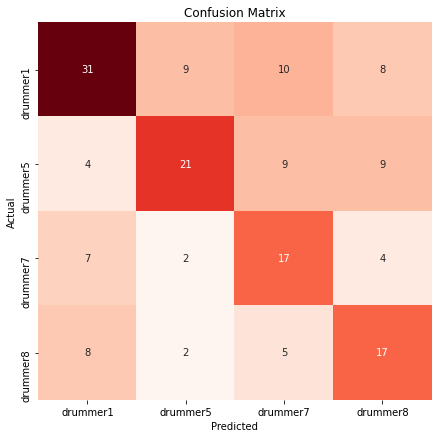

In [ ]:
# y = list of all y values from dataset
classes = np.unique(y)
KNN_results(predictions_1, y_test, classes)
c_matrix(predictions_1, y_test, classes)

# PCA
Appears there are diff types/ modes of PCA depending on when it's applied, e.g. if it's done on raw data or transformed/ scaled data. More info here ...
* https://stats.stackexchange.com/a/22126
* https://sebastianraschka.com/Articles/2014_about_feature_scaling.html


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.99, whiten=True)
#pca = PCA(whiten=True)

In [ ]:
def do_pca(data):
  features_pca = pca.fit_transform(data)  
  print('orig shape: {}, reduced pca:{}'.format(data.shape, features_pca.shape))
  display(pd.DataFrame(features_pca).head())

In [ ]:
do_pca(output1)
do_pca(output2)
do_pca(output3)
do_pca(output4)

orig shape: (812, 19), reduced pca:(812, 15)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,-1.098167,1.150492,0.013974,-0.258787,-0.071535,-0.004625,0.018944,0.009646,0.261782,-0.361161,2.791947,-1.269541,-0.318188,-0.460679,0.042537
1,-0.193561,-0.434346,0.001659,0.025796,-0.022219,-0.027441,-0.000752,0.014014,0.356608,-0.111623,0.259996,0.457096,1.028151,-0.151990,2.716074
2,-0.286544,-0.801079,-0.009639,0.484328,-1.080023,2.939082,0.216169,-0.230225,-0.449420,0.047791,-0.091127,0.233712,-0.221570,0.103587,-0.298595
3,1.833870,1.020820,2.048555,0.239342,0.014144,-0.023028,0.009455,0.003890,-0.231500,0.425605,0.051057,0.315711,-0.140732,-0.190370,-0.290934
4,0.518951,0.029395,2.057892,-0.051819,-0.173193,-0.104857,0.056215,0.056106,1.061477,-1.740970,0.219583,2.380089,-0.397217,0.192499,-0.167395


orig shape: (812, 5), reduced pca:(812, 2)


,0,1
0,-1.580774,-1.091477
1,-1.575524,0.160758
2,-1.138684,0.028968
3,-0.700041,1.995584
4,-0.701600,0.009718


orig shape: (812, 5), reduced pca:(812, 2)


,0,1
0,-1.580774,-1.091477
1,-1.575524,0.160758
2,-1.138684,0.028968
3,-0.700041,1.995584
4,-0.701600,0.009718


orig shape: (812, 19), reduced pca:(812, 13)


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.420215,-0.070457,-0.491390,1.588566,0.070156,-0.019155,0.014262,-0.007812,-0.038615,-0.357407,0.091517,0.923320,2.929450
1,0.282059,-0.184933,-0.304039,-0.328838,0.029493,-0.013493,-0.016666,-0.016966,-0.024082,-0.018007,0.339495,0.468036,-0.006691
2,0.225972,0.351013,-0.413831,-0.759015,-0.080881,-1.475434,2.755785,0.144661,-0.470495,0.180510,-0.391224,-0.006612,-0.156449
3,-0.419551,-0.612541,2.042580,0.147730,-2.025508,-0.031743,-0.045595,0.021857,0.096289,0.408106,-0.030860,-0.010444,-0.027522
4,0.077484,-0.496848,0.389061,-0.067418,-1.990246,-0.144022,-0.106209,0.005338,0.127696,-0.290536,0.632082,2.717717,-1.470485


# GridSearch on KNN with PCA

Good links!
* https://www.featureranking.com/tutorials/machine-learning-tutorials/sk-part-3-cross-validation-and-hyperparameter-tuning/ 
* https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
* https://scikit-learn.org/stable/modules/compose.html 
* https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors

NOTE: tested initially on this song filter ..
* style_filter = "3_soul-groove3"   

.. where was able to get 0.72 score!!

In [ ]:
from  sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

import sklearn
sklearn.__version__  # should be 0.23.2


'0.23.2'

## Setup

In [ ]:
# note: 'grid_cts' is list of ColumnTransformers from earlier.
# list of ColumnTransformers setup earlier ..
#grid_cts = [ct_v0, ct_v1, ct_v2, ct_v3, ct_v4]
#grid_cts = [ct_v2, ct_v3]
grid_cts = [ct_v4]

param_grid = dict(knn__n_neighbors=np.arange(1, 20), # knn neighbours
    knn__p=[1, 2, 5], # knn distance functions to test
    prep=grid_cts, # list of ColTransformers to search
    pca=['passthrough', PCA(n_components=0.99, whiten=True)]
)

my_pipe = Pipeline(steps=[('prep',ct), ('pca', PCA()), ('knn', KNeighborsClassifier())])
grid_search = GridSearchCV(my_pipe, param_grid=param_grid, cv=10, verbose=1)


## Do the search grid thing ...

In [ ]:
print('\n>>>>FITTING ....\n')
grid_search.fit(X,y)

# capture results in df
results_df = pd.DataFrame.from_dict(grid_search.cv_results_)
# display(results_df)

print('\n___BEST ESTIMATOR\n')
display(grid_search.best_estimator_)

print('\n___BEST SCORE\n')
display(grid_search.best_score_)

print('\n___BEST PARAMS\n')
display(grid_search.best_params_)





>>>>FITTING ....

Fitting 10 folds for each of 114 candidates, totalling 1140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1140 out of 1140 | elapsed:   39.9s finished


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(remainder='passthrough',
                                                          sparse_threshold=0,
                                                          transformers=[('t_scaler_std',
                                                                         StandardScaler(),
                                                                         [1,
                                                                          2]),
                                                                        ('t_one_hot',
                                                                         OneHotEncoder(drop='first'),
                                                                         [0]),
                                                                        ('t_one_hot_beat_pos',
                                                                         OneHotEncoder(categories=[[1,
                                                                                                    2,
                                                                                                    3,
                                                                                                    4,
                                                                                                    5,
                                                                                                    6,
                                                                                                    7,
                                                                                                    8,
                                                                                                    9,
                                                                                                    10,
                                                                                                    11,
                                                                                                    12,
                                                                                                    13,
                                                                                                    14,
                                                                                                    15,
                                                                                                    16]],
                                                                                       drop='first'),
                                                                         [3])])),
                                       ('pca', PCA()),
                                       ('knn', KNe...
                         'knn__p': [1, 2, 5],
                         'pca': ['passthrough',
                                 PCA(n_components=0.99, whiten=True)],
                         'prep': [ColumnTransformer(remainder='passthrough',
                                                    sparse_threshold=0,
                                                    transformers=[('t_scaler_std',
                                                                   StandardScaler(),
                                                                   [1, 2]),
                                                                  ('t_one_hot',
                                                                   OneHotEncoder(drop='first'),
                                                                   [0]),
                                                                  ('t_one_hot_beat_pos',
                                                                   OneHotEncoder(categories=[[1,
                                                                                              2,
                                 


___BEST ESTIMATOR



Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('t_scaler_std',
                                                  StandardScaler(), [1, 2]),
                                                 ('t_one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  [0]),
                                                 ('t_one_hot_beat_pos',
                                                  OneHotEncoder(categories=[[1,
                                                                             2,
                                                                             3,
                                                                             4,
                                                                             5,
                                                                             6,
                                                                             7,
                                                                             8,
                                                                             9,
                                                                             10,
                                                                             11,
                                                                             12,
                                                                             13,
                                                                             14,
                                                                             15,
                                                                             16]],
                                                                drop='first'),
                                                  [3])])),
                ('pca', PCA(n_components=0.99, whiten=True)),
                ('knn', KNeighborsClassifier(p=1))])


___BEST SCORE



0.524706413730804


___BEST PARAMS



{'knn__n_neighbors': 5,
 'knn__p': 1,
 'pca': PCA(n_components=0.99, whiten=True),
 'prep': ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                   transformers=[('t_scaler_std', StandardScaler(), [1, 2]),
                                 ('t_one_hot', OneHotEncoder(drop='first'), [0]),
                                 ('t_one_hot_beat_pos',
                                  OneHotEncoder(categories=[[1, 2, 3, 4, 5, 6, 7,
                                                             8, 9, 10, 11, 12,
                                                             13, 14, 15, 16]],
                                                drop='first'),
                                  [3])])}

## Chart results 

In [ ]:
grid_results = pd.DataFrame(grid_search.cv_results_['params'])
grid_results['test_score'] = grid_search.cv_results_['mean_test_score']
grid_results['metric'] = grid_results['knn__p'].replace([1,2,5], ["Manhattan", "Euclidean", "Minkowski"])
grid_results.shape
grid_results.head()

(114, 6)

,knn__n_neighbors,knn__p,pca,prep,test_score,metric
0,1,1,passthrough,"ColumnTransformer(remainder='passthrough', sparse_threshold=0,\n transformers=[('t_scaler_std', StandardScaler(), [1, 2]),\n ('t_one_hot', OneHotEncoder(drop='first'), [0]),\n ('t_one_hot_beat_pos',\n OneHotEncoder(categories=[[1, 2, 3, 4, 5, 6, 7,\n 8, 9, 10, 11, 12,\n 13, 14, 15, 16]],\n drop='first'),\n [3])])",0.511217,Manhattan
1,1,1,"PCA(n_components=0.99, whiten=True)","ColumnTransformer(remainder='passthrough', sparse_threshold=0,\n transformers=[('t_scaler_std', StandardScaler(), [1, 2]),\n ('t_one_hot', OneHotEncoder(drop='first'), [0]),\n ('t_one_hot_beat_pos',\n OneHotEncoder(categories=[[1, 2, 3, 4, 5, 6, 7,\n 8, 9, 10, 11, 12,\n 13, 14, 15, 16]],\n drop='first'),\n [3])])",0.496447,Manhattan
2,1,2,passthrough,"ColumnTransformer(remainder='passthrough', sparse_threshold=0,\n transformers=[('t_scaler_std', StandardScaler(), [1, 2]),\n ('t_one_hot', OneHotEncoder(drop='first'), [0]),\n ('t_one_hot_beat_pos',\n OneHotEncoder(categories=[[1, 2, 3, 4, 5, 6, 7,\n 8, 9, 10, 11, 12,\n 13, 14, 15, 16]],\n drop='first'),\n [3])])",0.497681,Euclidean
3,1,2,"PCA(n_components=0.99, whiten=True)","ColumnTransformer(remainder='passthrough', sparse_threshold=0,\n transformers=[('t_scaler_std', StandardScaler(), [1, 2]),\n ('t_one_hot', OneHotEncoder(drop='first'), [0]),\n ('t_one_hot_beat_pos',\n OneHotEncoder(categories=[[1, 2, 3, 4, 5, 6, 7,\n 8, 9, 10, 11, 12,\n 13, 14, 15, 16]],\n drop='first'),\n [3])])",0.497666,Euclidean
4,1,5,passthrough,"ColumnTransformer(remainder='passthrough', sparse_threshold=0,\n transformers=[('t_scaler_std', StandardScaler(), [1, 2]),\n ('t_one_hot', OneHotEncoder(drop='first'), [0]),\n ('t_one_hot_beat_pos',\n OneHotEncoder(categories=[[1, 2, 3, 4, 5, 6, 7,\n 8, 9, 10, 11, 12,\n 13, 14, 15, 16]],\n drop='first'),\n [3])])",0.500136,Minkowski


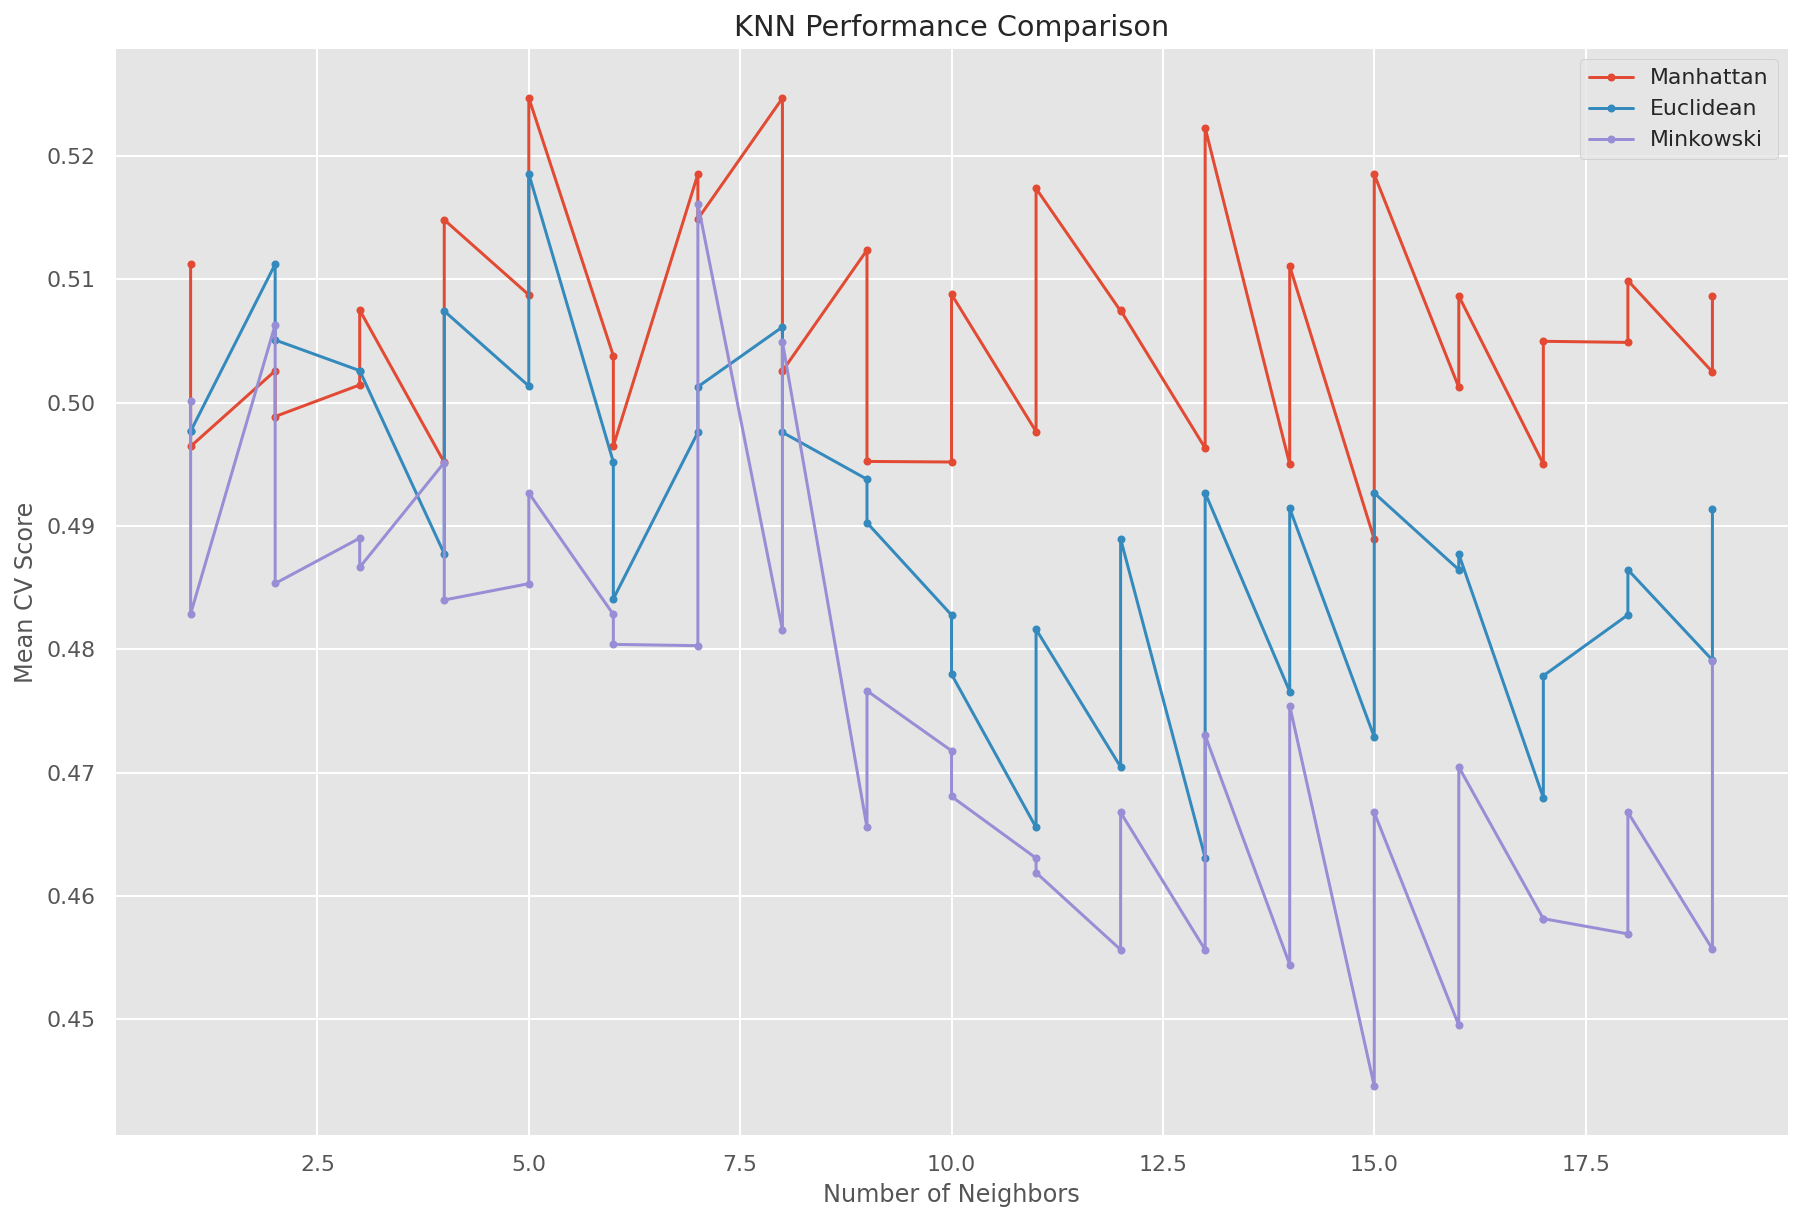

In [ ]:

import matplotlib.pyplot as plt

%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (15,10)

for i in ["Manhattan", "Euclidean", "Minkowski"]:
    temp = grid_results[grid_results['metric'] == i]
    _ = plt.plot(temp['knn__n_neighbors'], temp['test_score'], marker = '.', label = i)
    
_ = plt.legend()
_ = plt.xlabel('Number of Neighbors')
_ = plt.ylabel("Mean CV Score")
_ = plt.title("KNN Performance Comparison")
plt.show()

# DT (Decision Tree)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

df_classifier = DecisionTreeClassifier(random_state=999)

params_DT = {'criterion': ['gini', 'entropy'],
             'max_depth': [1, 2, 3, 4, 5, 6, 7, 8],
             'min_samples_split': [2, 3]}

gs_DT = GridSearchCV(estimator=df_classifier, 
                     param_grid=params_DT, 
                     verbose=1, 
                     scoring='accuracy')

gs_DT.fit(Data, target);

my_pipe = Pipeline(steps=[('prep',ct), ('pca', PCA()), ('knn', KNeighborsClassifier())])
grid_search = GridSearchCV(my_pipe, param_grid=param_grid, cv=10, verbose=1)


NameError: ignored